In [85]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [86]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils.vis_utils import plot_model

In [87]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [88]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [89]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [90]:
chat_in = []
chat_out = []

questions = []
answers = []
answers_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        questions.append(input_sentence)
        answers.append(output_sentence)
        answers_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(questions))

Cantidad de rows utilizadas: 6033


In [91]:
questions[1], answers[1], answers_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

##**Sin entrenar embeedding**

In [92]:
# Convertimos las preguntas y respuestas en secuencias numéricas
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers_inputs + answers)
question_seq = tokenizer.texts_to_sequences(questions)
answer_seq = tokenizer.texts_to_sequences(answers)
answer_input_seq = tokenizer.texts_to_sequences(answers_inputs)

In [93]:
# Obtenemos el tamaño máximo de las secuencias de entrada y salida
maxlen_input = max(len(s) for s in question_seq)
maxlen_output = max(len(s) for s in answer_seq)

In [94]:
# Rellenamos o truncamos las secuencias para que tengan la misma longitud
encoder_input_data = pad_sequences(question_seq, maxlen=maxlen_input, padding='post')
decoder_input_data = pad_sequences(answer_input_seq, maxlen=maxlen_output, padding='post')
decoder_target_data = pad_sequences(answer_seq, maxlen=maxlen_output, padding='post')


In [95]:
# Definimos las dimensiones de los embeddings y el tamaño del vocabulario
embedding_dim = 256
vocab_size = len(tokenizer.word_index) + 1

In [96]:
# Definimos las entradas de la red neuronal
encoder_inputs = Input(shape=(maxlen_input,))
decoder_inputs = Input(shape=(maxlen_output,))

In [97]:
# Definimos la capa de embeddings
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_input)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_output)


In [98]:
# Aplicamos la capa de embeddings a las entradas de la red neuronal
encoder_embedding_output = encoder_embedding(encoder_inputs)
decoder_embedding_output = decoder_embedding(decoder_inputs)

In [99]:
# Definimos la capa LSTM del encoder
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)
encoder_states = [state_h, state_c]

In [100]:
# Definimos la capa LSTM del decoder
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

In [101]:
# Definimos la capa densa de salida
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Definimos el modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilamos el modelo
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

# Entrenamos el modelo
hist =  model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=50, validation_split=0.2)



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 9, 256)       552448      ['input_11[0][0]']               
                                                                                                  
 embedding_9 (Embedding)        (None, 10, 256)      552448      ['input_12[0][0]']               
                                                                                            

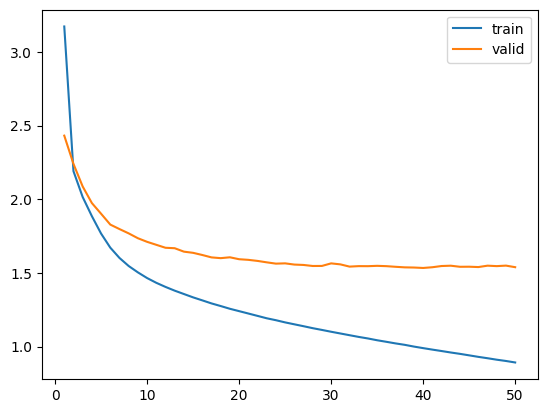

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

##**Con entrenar embeedding**

In [103]:
# Convertimos las preguntas y respuestas en secuencias numéricas
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers_inputs + answers)
question_seq = tokenizer.texts_to_sequences(questions)
answer_seq = tokenizer.texts_to_sequences(answers)
answer_input_seq = tokenizer.texts_to_sequences(answers_inputs)

In [104]:
# Obtenemos el tamaño máximo de las secuencias de entrada y salida
maxlen_input = max(len(s) for s in question_seq)
maxlen_output = max(len(s) for s in answer_seq)

In [105]:
# Rellenamos o truncamos las secuencias para que tengan la misma longitud
encoder_input_data = pad_sequences(question_seq, maxlen=maxlen_input, padding='post')
decoder_input_data = pad_sequences(answer_input_seq, maxlen=maxlen_output, padding='post')
decoder_target_data = pad_sequences(answer_seq, maxlen=maxlen_output, padding='post')


In [106]:
# Definimos las dimensiones de los embeddings y el tamaño del vocabulario
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

In [107]:
import urllib.request

# Descargar embeddings de GloVe
url = "http://nlp.stanford.edu/data/glove.6B.zip"
urllib.request.urlretrieve(url, "glove.6B.zip")

# Descomprimir el archivo
import zipfile
with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall()

In [108]:
# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [109]:
# Creamos la matriz de embeddings a partir de los embeddings pre-entrenados
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [110]:
# Definimos las entradas de la red neuronal
encoder_inputs = Input(shape=(maxlen_input,))
decoder_inputs = Input(shape=(maxlen_output,))

In [111]:
# Definimos la capa de embeddings con los embeddings pre-entrenados
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_input, weights=[embedding_matrix], trainable=False)
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen_output, weights=[embedding_matrix], trainable=False)


In [112]:
# Aplicamos la capa de embeddings a las entradas de la red neuronal
encoder_embedding_output = encoder_embedding(encoder_inputs)
decoder_embedding_output = decoder_embedding(decoder_inputs)

In [113]:
# Definimos la capa LSTM del encoder
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)
encoder_states = [state_h, state_c]


In [114]:
# Definimos la capa LSTM del decoder
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

In [115]:
# Definimos la capa densa de salida
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [116]:
# Definimos el modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilamos el modelo
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Entrenamos el modelo
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=100, validation_split=0.2)



Epoch 1/50
76/76 [==============================] - 20s 203ms/step - loss: 2.7977 - val_loss: 2.3317
Epoch 2/50
76/76 [==============================] - 14s 189ms/step - loss: 2.0539 - val_loss: 2.0945
Epoch 3/50
76/76 [==============================] - 15s 193ms/step - loss: 1.8617 - val_loss: 1.9578
Epoch 4/50
76/76 [==============================] - 14s 191ms/step - loss: 1.7151 - val_loss: 1.8879
Epoch 5/50
76/76 [==============================] - 15s 192ms/step - loss: 1.6276 - val_loss: 1.8150
Epoch 6/50
76/76 [==============================] - 15s 194ms/step - loss: 1.5655 - val_loss: 1.7758
Epoch 7/50
76/76 [==============================] - 15s 200ms/step - loss: 1.5198 - val_loss: 1.7546
Epoch 8/50
76/76 [==============================] - 16s 210ms/step - loss: 1.4802 - val_loss: 1.7305
Epoch 9/50
76/76 [==============================] - 14s 190ms/step - loss: 1.4475 - val_loss: 1.7088
Epoch 10/50
76/76 [==============================] - 15s 195ms/step - loss: 1.4180 - val_lo

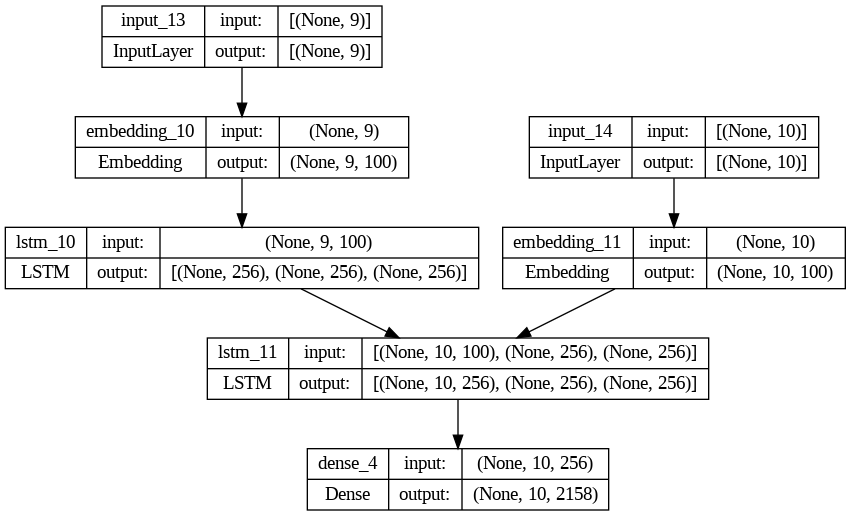

In [117]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

In [118]:
# Define inference model
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [119]:
reverse_word_index = {i: word for word, i in tokenizer.word_index.items()}

def generate_response(input_sentence):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(tokenizer.texts_to_sequences([input_sentence]))
  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  target_seq[0, 0] = tokenizer.word_index['start']

  generated_response = ''

  # Loop to generate response token by token
  while True:
    # Predict next token using decoder model and current decoder input and states
    decoder_output, h, c = decoder_model.predict([target_seq] + states_value)
    
    # Find index of predicted token with highest probability
    predicted_token_index = np.argmax(decoder_output[0, -1, :])
    
    # Look up corresponding word from index in reverse word index
    predicted_word = reverse_word_index[predicted_token_index]
    
    # If predicted word is <end>, stop generating response
    if predicted_word == '<end>' or len(generated_response.split()) >= maxlen_output:
        break
        
    # Add predicted word to generated response
    generated_response += ' ' + predicted_word
    
    # Update decoder input and states for next iteration
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = predicted_token_index
    states_value = [h, c]
    
  # Return generated response
  return generated_response.strip()

In [ ]:
for question in questions:
    input_seq = tokenizer.texts_to_sequences([question])
    input_seq = pad_sequences(input_seq, maxlen=maxlen_input, padding='post')
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index not in reverse_word_index:
            sampled_word = np.random.choice(list(reverse_word_index.values()))
        else:
            sampled_word = reverse_word_index[sampled_token_index]

        # Exit condition: either hit max length or find stop word
        if (sampled_word == 'end' or len(decoded_sentence) > maxlen_output):
            stop_condition = True
            continue

        decoded_sentence += ' ' + sampled_word

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    print('Q:', question)
    print('A:', decoded_sentence)

1/1 [==============================] - 0s 48ms/step
Q: hello 
A:  how are you
1/1 [==============================] - 0s 43ms/step
Q: hi how are you 
A:  i am fine eos
1/1 [==============================] - 0s 55ms/step
Q: hi 
A:  how are you
1/1 [==============================] - 0s 71ms/step
Q: hi 
A:  how are you
1/1 [==============================] - 0s 88ms/step
Q: hi 
A:  how are you
1/1 [==============================] - 0s 25ms/step
Q: where are you working 
A:  i am a student
1/1 [==============================] - 0s 26ms/step
Q: bro 
A:  what do you
1/1 [==============================] - 0s 25ms/step
Q: where are you from 
A:  i am not sure
1/1 [==============================] - 0s 28ms/step
Q: i am from russia and you 
A:  what do you
1/1 [==============================] - 0s 24ms/step
Q: i hate them most of the time 
A:  do you know
1/1 [==============================] - 0s 25ms/step
Q: i love disney movies 
A:  what do you
1/1 [==============================] - 0s 23ms/step